In [81]:
%matplotlib inline

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [82]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [83]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'BESTDATE', 'YEAR', 'QUARTER']
# AFF_UNITS, NET_AFF_UNITS, NAMEADDR, APN
distinct_columns = ['PERMIT_ID']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df

def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    X = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_DATE', 'PERMIT_STATUS_DATE'])
    X = X.set_index('PERMIT_ID')
    return X

permits = loadPermits()
    
df = loadData()
#print(df.head())
df = df[columns]
df["BESTSTAT"] = df["BESTSTAT"].str.upper()
df["BESTSTAT"][(df["BESTSTAT"] == "BP APPROVED") | (df["BESTSTAT"] == "PL APPROVED")] = "APPROVED"
df["BESTSTAT"][(df["BESTSTAT"] == "BP FILED") | (df["BESTSTAT"] == "PL FILED")] = "FILED"
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df['BESTDATE'] = pd.to_datetime(df['BESTDATE'], errors='coerce') # format='%m/%d/%Y', 
df.head()
#df.groupby("BESTSTAT").count()

,PERMIT_ID,UNITS,NET_UNITS,BESTDATE,YEAR,QUARTER
1,N200505273609,1,1,2014-01-24,2014,1
4,N200608179803,2,1,2014-02-04,2014,1
7,N200605111391,2,2,2014-03-18,2014,1
11,N200904065665,6,6,2013-01-08,2014,1
18,N201205180774,37,37,2014-01-08,2014,1


In [84]:
#df[(df["BESTSTAT"] == "CONSTRUCTION") & (df["YEAR"] == 2014)].sort_values(by=['NET_UNITS'], ascending=False)
#construction_start = df.sort(['BESTDATE', 'YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
#construction_start.rename(columns = {'BESTDATE':'STARTDATE'}, inplace = True)

construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="last")
#construction_end.rename(columns = {'BESTDATE':'ENDDATE'}, inplace = True)

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))
# not applicable as BESTDATE seems not to be updated 
#data['DURATION'] = (data['ENDDATE'] - data['STARTDATE']) / np.timedelta64(1, 'D')

data = data[~data.duplicated('PERMIT_ID')]

data = data.set_index('PERMIT_ID')

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

data['PERMIT_DATE_YEAR'] = pd.DatetimeIndex(data['PERMIT_DATE']).year
data['PERMIT_DATE_QUARTER'] = pd.DatetimeIndex(data['PERMIT_DATE']).quarter

data['DURATION'] = (data['YEAR_END'] - data['PERMIT_DATE_YEAR']) * 4 + data['QUARTER_END'] - data['PERMIT_DATE_QUARTER'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', # , 'PERMIT_DATE', 'YEAR_START', 'QUARTER_START'
             'PERMIT_DATE_YEAR', 'PERMIT_DATE_QUARTER', 'DURATION', 'PERMIT_STATUS', 'PERMIT_STATUS_DATE']]
data.head() 

565
530


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,PERMIT_STATUS,PERMIT_STATUS_DATE
PERMIT_ID,,,,,,,,,
N200505273609,1,1,2015,1,2005,2,40,complete,06/24/2015
N200605111391,2,2,2017,1,2006,2,44,reinstated,04/20/2011
N200904065665,6,6,2016,1,2009,2,28,complete,08/22/2012
N201205180774,37,37,2014,4,2012,2,11,issued,12/27/2012
N201301097560,3,1,2014,3,2013,1,7,complete,12/03/2014


In [85]:
#print(data.count() == data[data['DURATION'] > 1].count())
not_completed_ids = data[(data['YEAR_END'] == 2017)].index
complete = data[~data.index.isin(not_completed_ids)]
incomplete = data[data.index.isin(not_completed_ids)]
print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())
#complete.sort_values(['NET_UNITS'], ascending=False)

Completed by 2017:  358
Still in construction by 2017:  172


In [86]:
print("Median ", complete['DURATION'].median())
print("Mean ", str(complete['DURATION'].mean()))

print("Median net units", complete['NET_UNITS'].median()) # few big buildings
#print("Long in costruction, net units: ", complete[complete['DURATION'] > 4]['NET_UNITS'].mean())
#print("Not long in costruction, net units: ", complete[complete['DURATION'] <= 4]['NET_UNITS'].mean())

# not much difference
print("\nBigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].mean())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].mean())

print("Bigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].median())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].median())

Median  13.0
Mean  17.33240223463687
Median net units 1.0

Bigger buildings:  18.485294117647058
Smaller buildings:  17.06206896551724
Bigger buildings:  14.0
Smaller buildings:  12.5


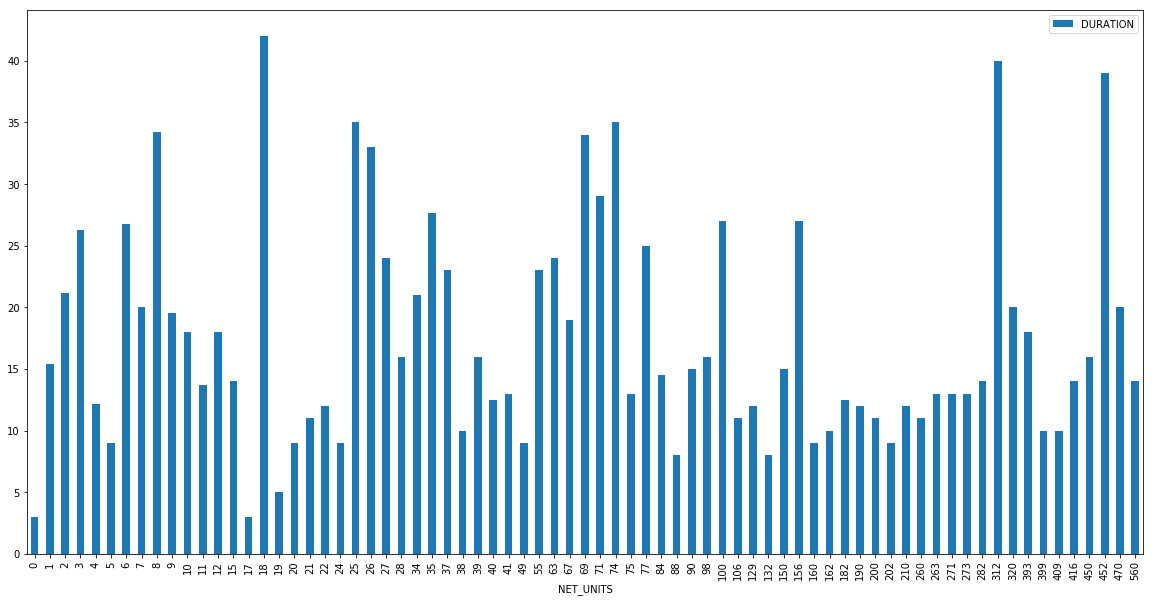

In [87]:
# net units to duration
# df.groupby(['cluster']).mean()
# complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean().plot(x = 'NET_UNITS', y = 'DURATION', kind = "bar", figsize=(20,10))

grouped = complete.sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10))

In [88]:
complete.sort_values(['NET_UNITS'], ascending=False).head()

,UNITS,NET_UNITS,YEAR_END,QUARTER_END,PERMIT_DATE_YEAR,PERMIT_DATE_QUARTER,DURATION,PERMIT_STATUS,PERMIT_STATUS_DATE
PERMIT_ID,,,,,,,,,
N201306250394,560,560,2016,3,2013,2,14,issued,07/08/2014
N201112070227,470,470,2016,3,2011,4,20,complete,05/15/2017
N200605161774,452,452,2015,4,2006,2,39,complete,02/10/2017
N201209059006,450,450,2016,2,2012,3,16,issued,08/02/2013
N201307303137,416,416,2016,4,2013,3,14,issued,03/20/2014


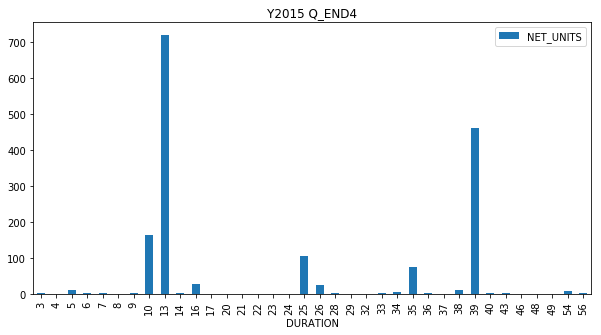

In [89]:
def plot_duration(year, quarter_end):
    d1 = complete[(complete['YEAR_END'] == year) & (complete['QUARTER_END'] == quarter_end)]
    grouped = d1.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
    grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(10,5), title = "Y" + str(year) + " Q_END" + str(quarter_end))

#plot_duration(2015, 1)
#plot_duration(2015, 2)
#plot_duration(2015, 3)
plot_duration(2015, 4)

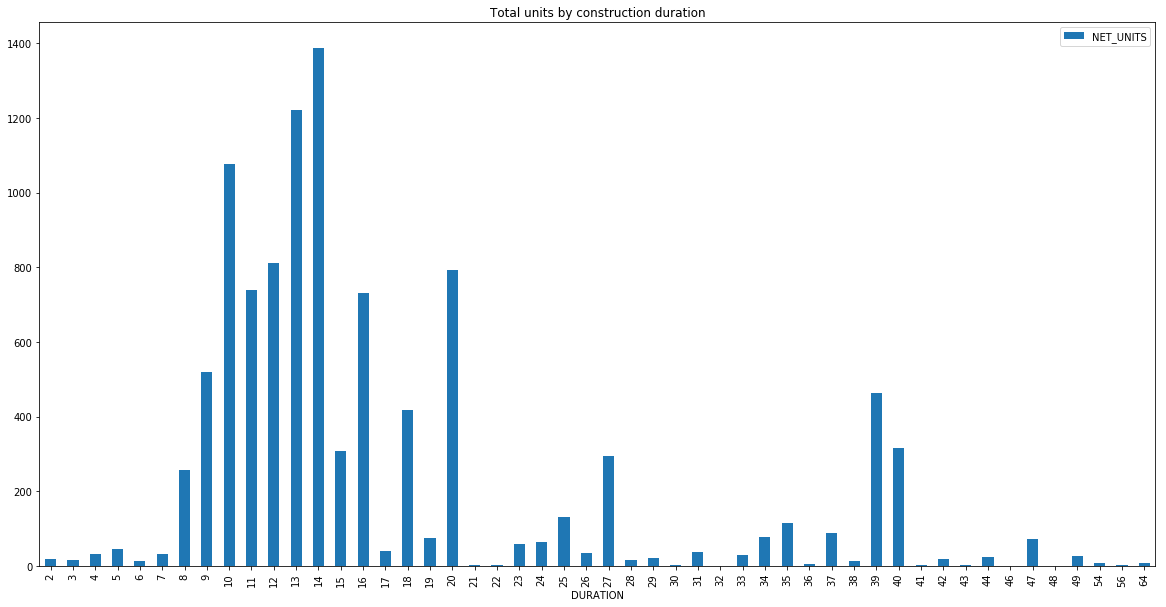

In [90]:
grouped = complete.sort_values(['NET_UNITS']).groupby(['DURATION']).sum()
grouped.plot(y = 'NET_UNITS', kind = "bar", figsize=(20,10), title="Total units by construction duration")

In [91]:
#complete['PERMIT_DATE_YEAR'] = 2017 - complete['PERMIT_DATE_YEAR']
#incomplete['PERMIT_DATE_YEAR'] = 2017 - incomplete['PERMIT_DATE_YEAR']

# if permit status is "complete"
complete['PERMIT_STATUS'] = pd.get_dummies( complete['PERMIT_STATUS'] )['complete']
incomplete['PERMIT_STATUS'] = pd.get_dummies( incomplete['PERMIT_STATUS'] )['complete']

columns_to_show = ['UNITS', 'NET_UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_STATUS', 'DURATION',
                   'DURATION_PREDICTED']

In [92]:
X_train, X_val, y_train, y_val = train_test_split(
    complete, 
    complete['DURATION'], 
    test_size=0.1) 
    #random_state=40)

# linear regression 11.09
#model = linear_model.LinearRegression(fit_intercept=True, normalize=True)
model = RandomForestRegressor(max_depth=2, criterion="mse", warm_start=True)
model.fit(X_train[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_STATUS']], y_train)

#print('Coefficients: \n', model.coef_)
print(model.feature_importances_)

y_val_predicted = model.predict(X_val[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_STATUS']])
X_val['DURATION_PREDICTED'] = np.ceil(y_val_predicted)

#X_val['DURATION_PREDICTED'][X_val['DURATION_PREDICTED'] < 13] = X_val['DURATION_PREDICTED'] * 1.3
# prediction error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_val_predicted))
print("Mean absolute error: %.2f" % mean_absolute_error(y_val, y_val_predicted))

X_val[columns_to_show].sort_values(by=['NET_UNITS'],ascending=False).head(15)

[ 0.  1.  0.]
Mean squared error: 14.98
Mean absolute error: 3.35


,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_STATUS,DURATION,DURATION_PREDICTED
PERMIT_ID,,,,,,
N201112070227,470,470,2011,1,20,18.0
N201409116118,202,202,2014,0,9,10.0
N200712211199,100,100,2007,0,27,31.0
N200711077587,80,77,2007,0,37,31.0
N201312124038,12,12,2013,1,11,10.0
N201105256770,10,10,2011,1,18,18.0
N201202295146,9,9,2012,1,15,11.0
N201202295145,9,9,2012,1,16,11.0
N200904065665,6,6,2009,1,28,31.0


In [93]:
duration_predicted = model.predict(incomplete[['UNITS', 'PERMIT_DATE_YEAR', 'PERMIT_STATUS']])
incomplete['DURATION_PREDICTED'] = np.ceil(duration_predicted)
incomplete.sort_values(by=['NET_UNITS'],ascending=False)

# shows that basically all buildings not finished yet should be finished already :D
incomplete['QUARTERS_LEFT'] = incomplete['DURATION_PREDICTED'] - incomplete['DURATION']
incomplete[columns_to_show + ['QUARTERS_LEFT']].head(20)

,UNITS,NET_UNITS,PERMIT_DATE_YEAR,PERMIT_STATUS,DURATION,DURATION_PREDICTED,QUARTERS_LEFT
PERMIT_ID,,,,,,,
N200605111391,2,2,2006,0,44,36.0,-8.0
N200607106046,1,1,2006,0,43,36.0,-7.0
N200809262740,2,1,2008,0,35,31.0,-4.0
N200912304034,2,2,2009,0,30,31.0,1.0
N201002035833,3,1,2010,0,29,19.0,-10.0
N201012106469,1,1,2010,0,26,19.0,-7.0
N200602215057,35,35,2006,0,45,36.0,-9.0
N201106279018,2,1,2011,0,24,18.0,-6.0
N201209200274,4,4,2012,0,19,11.0,-8.0
